# Importing Packages

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Extracting Data from source

In [3]:
# Establishing connection
conn = sqlite3.connect('cleaned_credit_fraud_data.db')
# Creating a cursor object
cursor = conn.cursor()

In [4]:
# Querying the data
cursor.execute('SELECT * FROM fraudTrain')
data = cursor.fetchall()

columns = [i[0] for i in cursor.description]
# Extracting the data into pandas dataframe
df = pd.DataFrame(data, columns = columns)

In [5]:
df.head()

,field1,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,...,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,distance,full_name,age
0,0,2019-01-01 00:00:18,2.703186e+15,"Rippin, Kub and Mann",misc_net,4.97,F,Perry Cove,Moravian Falls,NC,...,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,78.597680,Jennifer Banks,30
1,1,2019-01-01 00:00:44,6.304233e+11,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Riley Greens Suite,Orient,WA,...,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,30.212218,Stephanie Gill,40
2,2,2019-01-01 00:00:51,3.885949e+13,Lind-Buckridge,entertainment,220.11,M,White Dale Suite,Malad City,ID,...,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,108.206235,Edward Sanchez,56
3,3,2019-01-01 00:01:16,3.534094e+15,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Cynthia Court Apt.,Boulder,MT,...,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,95.673366,Jeremy White,51
4,4,2019-01-01 00:03:06,3.755342e+14,Keeling-Crist,misc_pos,41.96,M,Bradley Rest,Doe Hill,VA,...,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,77.556853,Tyler Garcia,32


# EDA

In [6]:
df.shape

(1296675, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   field1                 1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  float64
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   gender                 1296675 non-null  object 
 7   street                 1296675 non-null  object 
 8   city                   1296675 non-null  object 
 9   state                  1296675 non-null  object 
 10  zip                    1296675 non-null  int64  
 11  lat                    1296675 non-null  float64
 12  long                   1296675 non-null  float64
 13  city_pop               1296675 non-null  int64  
 14  job               

Wont require Latitude, longitude data as city and distance data is enough for analysis

In [8]:
df.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis = 1, inplace = True)

field1 is just unique identifier, cc_num is the credit card number,. we won't require both during our analysis phase

In [9]:
df.drop(['field1', 'cc_num'], axis = 1, inplace = True)

In [10]:
# Lets try and divide the columns into respective data types

In [11]:
dt = 'trans_date_trans_time'
numeric = ['amt', 'city_pop', 'distance', 'age']
cat = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job', 'full_name']

# Target

In [12]:
df['is_fraud'].unique()

array([0, 1], dtype=int64)

In [13]:
df['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [14]:
df['is_fraud'].value_counts(normalize=True)

0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

The target variable is binary. As stated in the problem statement, we have to identify the fraudulent transactions.

99.4% of transactions are legit, only 0.6% of transactions are fraud.

The data is severely imbalanced. We now have to set metrics so as to evalute our model performance.

We have 3 options: 

    Precision: Out of all the Frauds predicted by our model, how many were actually frauds.

    Recall: Out of total frauds, how many does our model identifies correctly.
    
There is usually a trade-off between both the metrics, If both the metrics are equally important, then we can choose f1_score:

    f1-score: Harmonic mean of Precision and Recall. Weighs both metrics equally.

Now, as a bank, do we need to identify all the frauds correctly and fail to catch a few fraud transactions or do we need to capture as many fraud transactions as possible but misclassify a few legit transactions as fraud.

If we choose recall, we may catch all the fraud transactions and prevent major loss to the bank, but if we misclassify legit transactions as frauds, we may inconvience customers and result in increased churn rate.

If we choose precision we will classify majority of the fraud transactions correctly and prevent inconvinience to the customers, but we will miss a few fraudulent transactions, causing loss to the bank.

In the end, what is more important, Preventing loss to bank or preventing inconvinience?

Lets check the amount of loss occured in fraud.

In [15]:
df[df['is_fraud'] == 1]['amt'].sum()

3988088.6100000003

In [16]:
df[df['is_fraud'] == 1]['amt'].mean()

531.3200919264573

     So the bank lost an avg of $500 on every fraud transaction. And 7506 frauds adds up to $3.9 million loss in time frame of 1.5 years.

So, we wil be choosing recall as our metric.

## datetime

### trans_date_trans_time

In [17]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [18]:
print('This data contains transaction info of {}'.format(df['trans_date_trans_time'].max() - df['trans_date_trans_time'].min()))

This data contains transaction info of 537 days 12:13:19


In [19]:
print('The first transaction record is for {}'.format(df['trans_date_trans_time'].min()))
print('The last transaction record is for {}'.format(df['trans_date_trans_time'].max()))

The first transaction record is for 2019-01-01 00:00:18
The last transaction record is for 2020-06-21 12:13:37


<AxesSubplot:xlabel='trans_date_trans_time'>

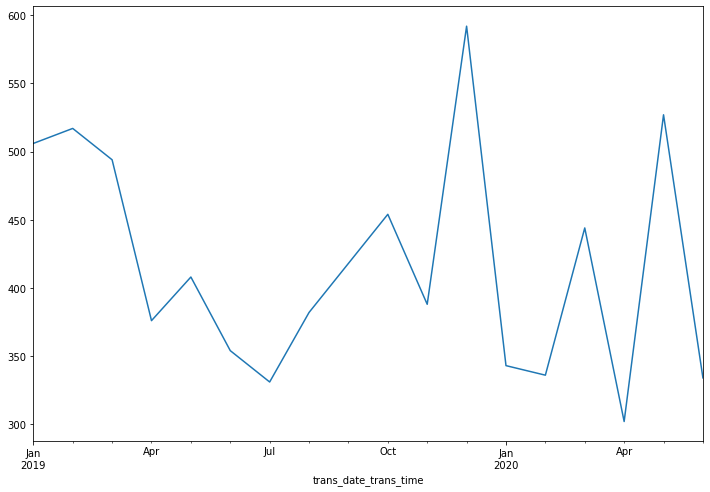

In [90]:
df.resample('M',on = 'trans_date_trans_time')['is_fraud'].sum().plot(figsize = (12,8))

## Numeric

In [20]:
numeric

['amt', 'city_pop', 'distance', 'age']

In [21]:
def numeric_summary_stats(col):
    print('Mean    = ', df[col].mean())
    print()
    print('Minimum = ', df[col].min())
    print('25%     = ', np.quantile(df[col], 0.25))
    print('Median  = ', np.quantile(df[col], 0.5))
    print('75%     = ', np.quantile(df[col], 0.75))
    print('Maximum = ', df[col].max())

In [22]:
def outliers(col):
    percentile_75 = np.quantile(df[col], 0.75)
    percentile_25 = np.quantile(df[col], 0.25)
    iqr = percentile_75 - percentile_25

    upper_limit = percentile_75 + (1.5 * iqr)

    print('Upper_limit is ', upper_limit)

    print('No of outliers in column = ', df[df[col]>upper_limit].shape[0])
    
    return upper_limit

### amt

The variable gives the amount in each transaction

In [23]:
numeric_summary_stats('amt')

Mean    =  70.35103545606833

Minimum =  1.0
25%     =  9.65
Median  =  47.52
75%     =  83.14
Maximum =  28948.9


Data upto 3rd quartile is under 83.14, while the max is 28948. This suggest existence of outliers towards right side of the data. Lets check the data for outliers (amount and number both)

The data is skewed towards Right.

We will find the outliers via IQR range

In [24]:
outliers('amt')

Upper_limit is  193.375
No of outliers in column =  67290


193.375

Lets remove the outliers and see hwo the distribution is like.

<AxesSubplot:xlabel='amt', ylabel='Density'>

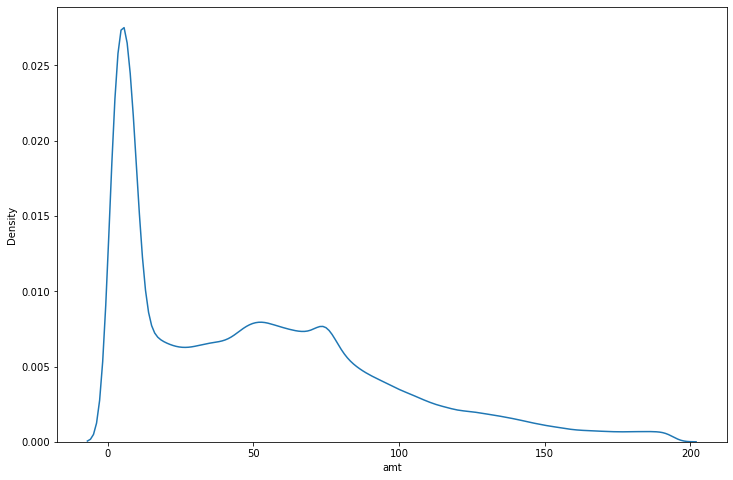

In [25]:
plt.figure(figsize = (12,8))
sns.kdeplot(x = 'amt', data = df[df['amt'] < 194])

<AxesSubplot:xlabel='is_fraud', ylabel='amt'>

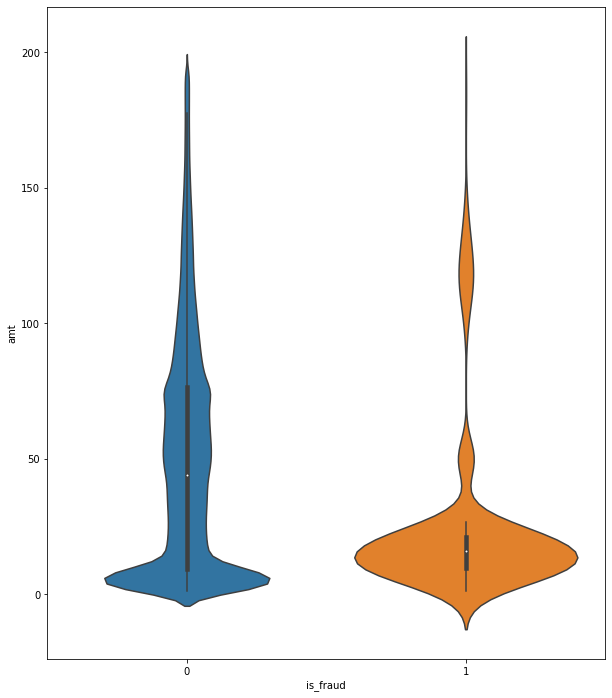

In [26]:
plt.figure(figsize = (10,12))
sns.violinplot(x = 'is_fraud', y = 'amt', data = df[df['amt']<194])

In [27]:
print('Data for Fraud transactions without outliers')
print('Mean    = ', df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'].mean())
print()
print('Minimum = ', df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'].min())
print('25%     = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'], 0.25))
print('Median  = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'], 0.5))
print('75%     = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'], 0.75))
print('Maximum = ', df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'].max())

Data for Fraud transactions without outliers
Mean    =  25.063126041088303

Minimum =  1.06
25%     =  9.55
Median  =  16.02
75%     =  20.94
Maximum =  191.87


In [28]:
print('Data for legal transactions without outliers')
print('Mean    = ', df[(df['amt'] < 194) & (df['is_fraud'] == 0)]['amt'].mean())
print()
print('Minimum = ', df[(df['amt'] < 194) & (df['is_fraud'] == 0)]['amt'].min())
print('25%     = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 0)]['amt'], 0.25))
print('Median  = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 0)]['amt'], 0.5))
print('75%     = ', np.quantile(df[(df['amt'] < 194) & (df['is_fraud'] == 1)]['amt'], 0.75))
print('Maximum = ', df[(df['amt'] < 194) & (df['is_fraud'] == 0)]['amt'].max())

Data for legal transactions without outliers
Mean    =  50.548585743517364

Minimum =  1.0
25%     =  9.15
Median  =  43.95
75%     =  20.94
Maximum =  193.99


In [29]:
#Outliers
df[df['amt'] > 193]['is_fraud'].value_counts()

0    61890
1     5705
Name: is_fraud, dtype: int64

In [30]:
print('% of total frauds where amt is an outlier:',
      df[(df['amt']>193) & df['is_fraud'] == 1].shape[0]/df[df['is_fraud'] == 1].shape[0])

% of total frauds where amt is an outlier: 0.76005861977085


So 76% of the fraudulent transactions have high transaction amount 

<AxesSubplot:xlabel='is_fraud', ylabel='amt'>

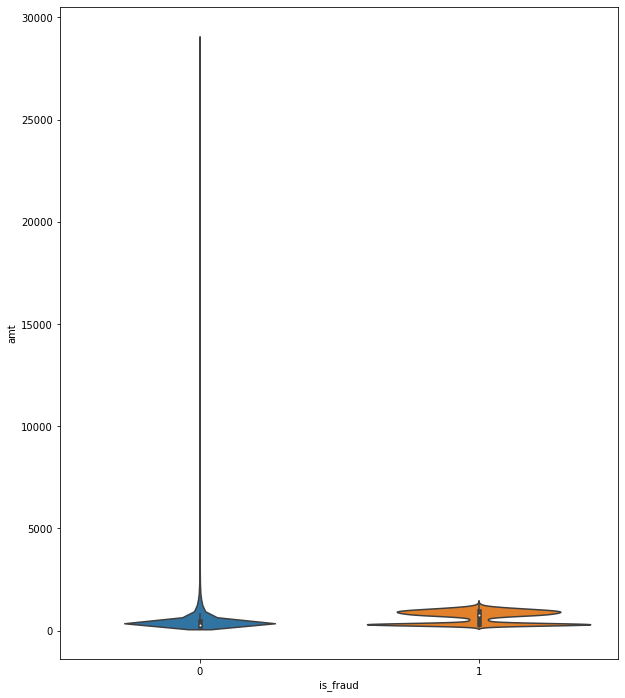

In [31]:
plt.figure(figsize = (10,12))
sns.violinplot(x = 'is_fraud', y = 'amt', data = df[df['amt']>193])

In [32]:
print('Data for Fraud transactions with outliers')
print('Mean    = ', df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'].mean())
print()
print('Minimum = ', df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'].min())
print('25%     = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'], 0.25))
print('Median  = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'], 0.5))
print('75%     = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'], 0.75))
print('Maximum = ', df[(df['amt'] > 193) & (df['is_fraud'] == 1)]['amt'].max())

Data for Fraud transactions with outliers
Mean    =  691.1393374233118

Minimum =  197.33
25%     =  326.04
Median  =  786.4
75%     =  948.05
Maximum =  1376.04


In [33]:
print('Data for Fraud transactions with outliers')
print('Mean    = ', df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'].mean())
print()
print('Minimum = ', df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'].min())
print('25%     = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'], 0.25))
print('Median  = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'], 0.5))
print('75%     = ', np.quantile(df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'], 0.75))
print('Maximum = ', df[(df['amt'] > 193) & (df['is_fraud'] == 0)]['amt'].max())

Data for Fraud transactions with outliers
Mean    =  408.9937705606679

Minimum =  193.01
25%     =  214.02
Median  =  259.69
75%     =  446.7275
Maximum =  28948.9


We can make a new feature called 'is_outlier_amt' for classification

### city_pop

Population of city in which the user lives

In [34]:
numeric_summary_stats('city_pop')

Mean    =  88824.44056297839

Minimum =  23
25%     =  743.0
Median  =  2456.0
75%     =  20328.0
Maximum =  2906700


<AxesSubplot:xlabel='city_pop', ylabel='Density'>

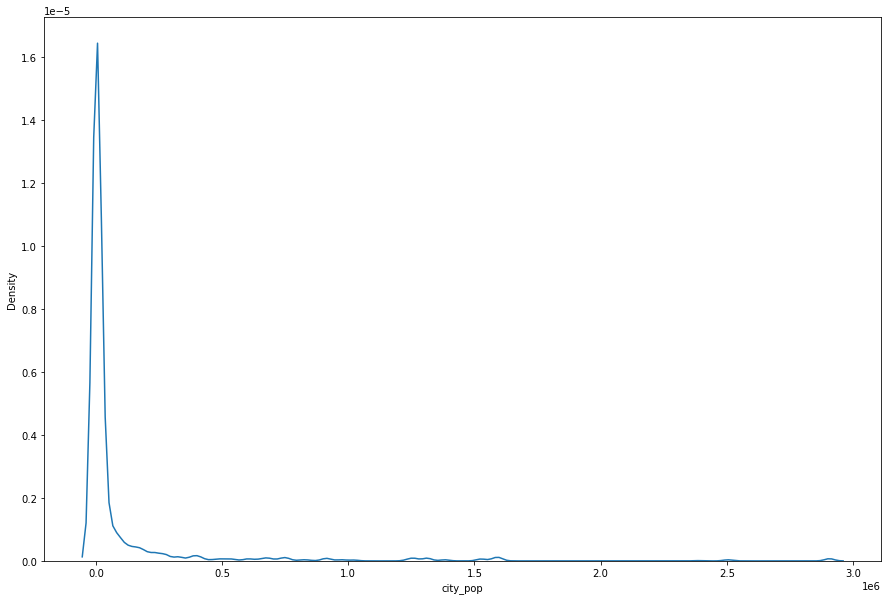

In [35]:
plt.figure(figsize = (15,10))
sns.kdeplot(x = 'city_pop', data = df)

In [36]:
outliers('city_pop')

Upper_limit is  49705.5
No of outliers in column =  242674


49705.5

### distance

Gives the distance between user's home and where the transaction occured

In [37]:
numeric_summary_stats('distance')

Mean    =  76.11475812739239

Minimum =  0.022254547076406873
25%     =  55.334991597630186
Median  =  78.23186180649904
75%     =  98.50340743557823
Maximum =  152.11738799443842


<AxesSubplot:xlabel='distance', ylabel='Density'>

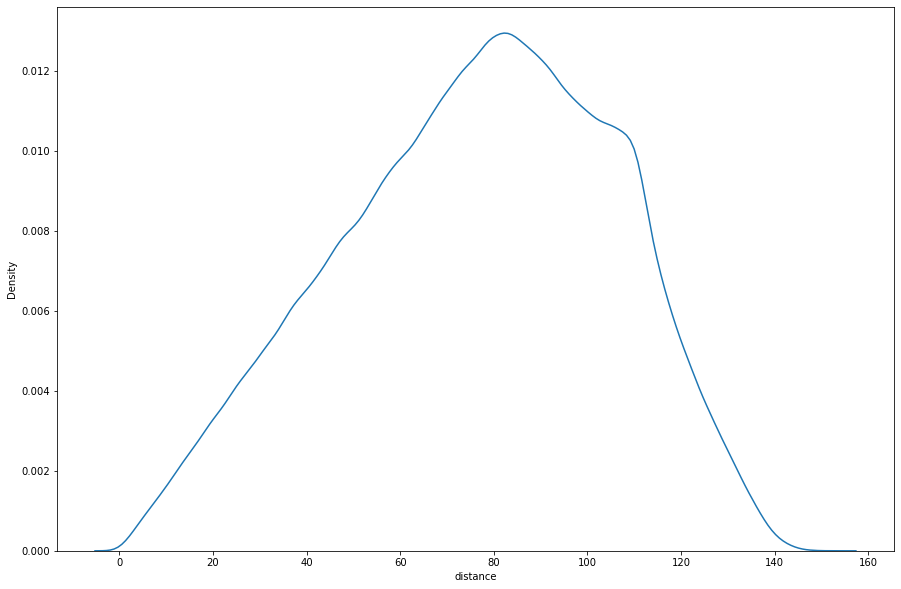

In [38]:
plt.figure(figsize = (15,10))
sns.kdeplot(x = 'distance', data = df)

<AxesSubplot:xlabel='is_fraud', ylabel='distance'>

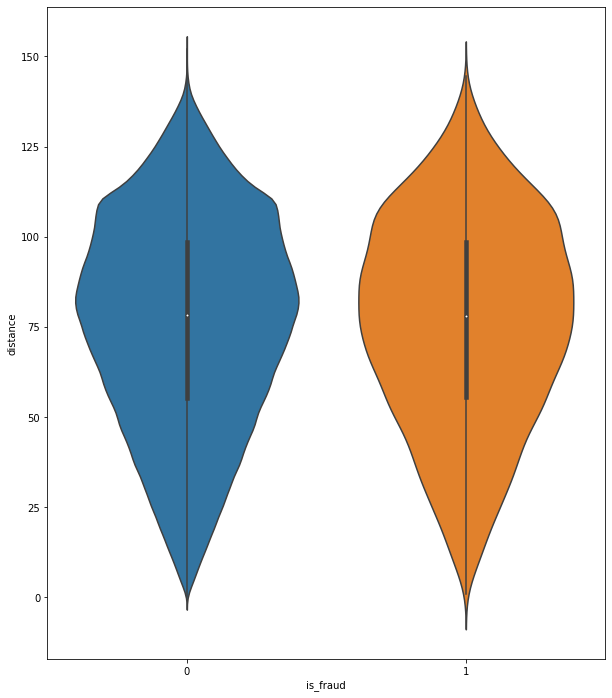

In [39]:
plt.figure(figsize = (10,12))
sns.violinplot(x = 'is_fraud', y = 'distance', data = df)

### age

In [40]:
numeric_summary_stats('age')

Mean    =  45.49740682900495

Minimum =  13
25%     =  32.0
Median  =  43.0
75%     =  57.0
Maximum =  95


<AxesSubplot:xlabel='age', ylabel='Density'>

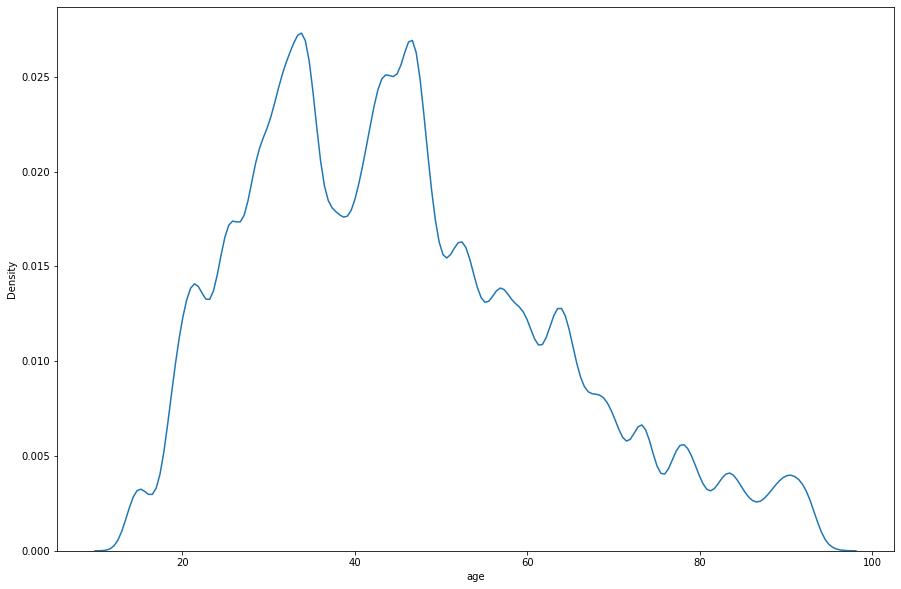

In [41]:
plt.figure(figsize = (15,10))
sns.kdeplot(x = 'age', data = df)

<AxesSubplot:xlabel='is_fraud', ylabel='age'>

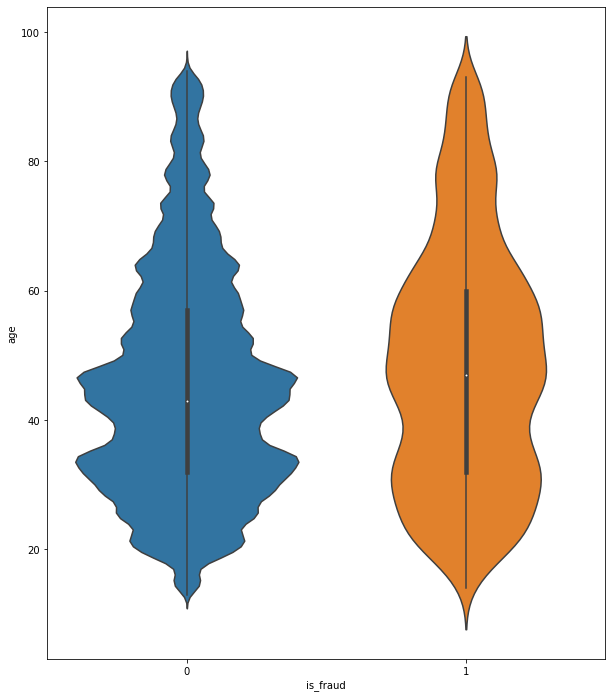

In [42]:
plt.figure(figsize = (10,12))
sns.violinplot(x = 'is_fraud', y = 'age', data = df)

## Categorical

In [43]:
cat

['merchant',
 'category',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'job',
 'full_name']

### merchant

In [44]:
df['merchant'].nunique()

693

In [45]:
df['merchant'].value_counts()

Kilback LLC                       4403
Cormier LLC                       3649
Schumm PLC                        3634
Kuhn LLC                          3510
Boyer PLC                         3493
                                  ... 
Treutel-King                       775
Douglas, DuBuque and McKenzie      775
Medhurst, Labadie and Gottlieb     759
Reichert-Weissnat                  753
Hahn, Douglas and Schowalter       727
Name: merchant, Length: 693, dtype: int64

In [46]:
#The merchants where most no of frauds have occured
df[df['is_fraud'] == 1]['merchant'].value_counts().head(15)

Rau and Sons         49
Kozey-Boehm          48
Cormier LLC          48
Vandervort-Funk      47
Doyle Ltd            47
Kilback LLC          47
Kuhn LLC             44
Padberg-Welch        44
Terry-Huel           43
Koepp-Witting        42
Jast Ltd             42
Goyette Inc          42
Kerluke-Abshire      41
Kiehn-Emmerich       41
McDermott-Weimann    41
Name: merchant, dtype: int64

In [47]:
merchants = df[df['is_fraud'] == 1]['merchant'].unique()

In [48]:
non_frauds = []
def merch(row):
    if row['merchant'] not in merchants:
        non_frauds.append(row['merchant'])
            
    return row

df = df.apply(merch, axis= 1)

In [49]:
non_frauds = set(non_frauds)

In [50]:
non_frauds

{'Funk Group',
 'Gulgowski LLC',
 'Hodkiewicz, Prohaska and Paucek',
 'Larson, Quitzon and Spencer',
 'McKenzie-Huels',
 'Osinski Inc',
 'Parker, Nolan and Trantow',
 'Paucek-Wiza',
 'Reichert-Weissnat',
 'Ritchie, Bradtke and Stiedemann',
 'Romaguera and Sons',
 'Schroeder Group',
 'Schroeder, Wolff and Hermiston',
 'Wiegand-Lowe'}

These stores never had any fraudulent transactions.

<AxesSubplot:>

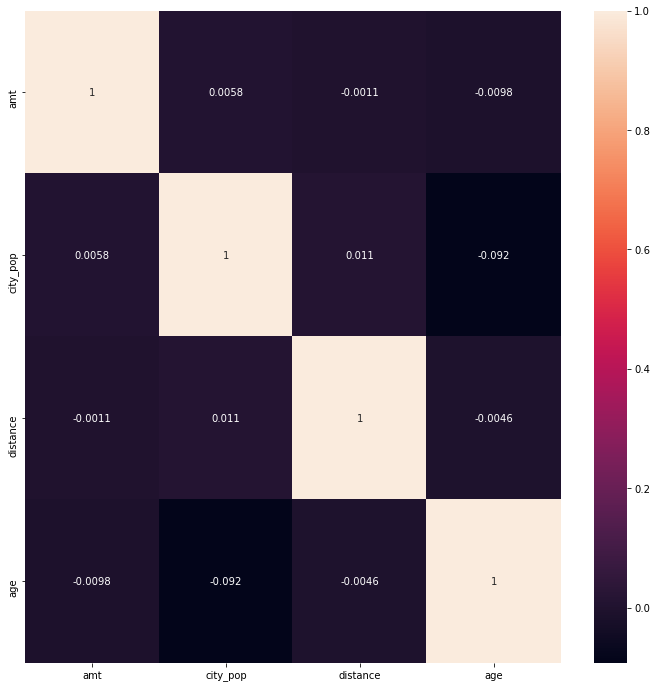

In [83]:
# Checking for correlation
plt.figure(figsize = (12,12))
sns.heatmap(df[numeric].corr(), annot = True)

There is no multicollinearity

### category

In [51]:
df['category'].nunique()

14

In [52]:
df['category'].value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

In [53]:
df.groupby('category')['is_fraud'].value_counts(normalize = True)*100

category        is_fraud
entertainment   0           99.752165
                1            0.247835
food_dining     0           99.834902
                1            0.165098
gas_transport   0           99.530606
                1            0.469394
grocery_net     0           99.705183
                1            0.294817
grocery_pos     0           98.590239
                1            1.409761
health_fitness  0           99.845131
                1            0.154869
home            0           99.839175
                1            0.160825
kids_pets       0           99.788561
                1            0.211439
misc_net        0           98.554205
                1            1.445795
misc_pos        0           99.686147
                1            0.313853
personal_care   0           99.757597
                1            0.242403
shopping_net    0           98.243851
                1            1.756149
shopping_pos    0           99.277462
                1        

In [54]:
df.groupby('category')['is_fraud'].value_counts()

category        is_fraud
entertainment   0            93781
                1              233
food_dining     0            91310
                1              151
gas_transport   0           131041
                1              618
grocery_net     0            45318
                1              134
grocery_pos     0           121895
                1             1743
health_fitness  0            85746
                1              133
home            0           122917
                1              198
kids_pets       0           112796
                1              239
misc_net        0            62372
                1              915
misc_pos        0            79405
                1              250
personal_care   0            90538
                1              220
shopping_net    0            95830
                1             1713
shopping_pos    0           115829
                1              843
travel          0            40391
                1             

### gender

In [55]:
df['gender'].value_counts()

F    709863
M    586812
Name: gender, dtype: int64

In [56]:
df.groupby('gender')['is_fraud'].value_counts()

gender  is_fraud
F       0           706128
        1             3735
M       0           583041
        1             3771
Name: is_fraud, dtype: int64

For ethical reasons, gender shouldn't be considered as a factor while predicting fraud.

### street

In [57]:
df['street'].nunique()

982

In [58]:
#This feature will be dropped

### city

In [100]:
df['city'].nunique()

894

In [59]:
df['city']

0                    Moravian Falls
1                            Orient
2                        Malad City
3                           Boulder
4                          Doe Hill
                     ...           
1296670                       Hatch
1296671                   Tuscarora
1296672    High Rolls Mountain Park
1296673                   Manderson
1296674                        Sula
Name: city, Length: 1296675, dtype: object

In [60]:
df['city'].value_counts().head(20)

Birmingham      5617
San Antonio     5130
Utica           5105
Phoenix         5075
Meridian        5060
Thomas          4634
Conway          4613
Cleveland       4604
Warren          4599
Houston         4168
Burbank         4159
Naples          4155
Arcadia         4096
Indianapolis    4073
Brandon         4044
Fulton          3977
Lahoma          3646
Allentown       3639
Lakeland        3635
Dallas          3629
Name: city, dtype: int64

In [61]:
idx = df['city'].value_counts().head(30).index

In [62]:
mask = [True if i in idx else False for i in df['city']]

In [63]:
df[mask].groupby('city')['is_fraud'].value_counts(normalize = True)*100

city           is_fraud
Allentown      0            99.422918
               1             0.577082
Andrews        0            99.722145
               1             0.277855
Arcadia        0            99.560547
               1             0.439453
Birmingham     0            99.804166
               1             0.195834
Brandon        0            99.480712
               1             0.519288
Burbank        0            99.567204
               1             0.432796
Cleveland      0            99.609036
               1             0.390964
Conway         0            99.631476
               1             0.368524
Dallas         0            99.255993
               1             0.744007
Detroit        0            99.274554
               1             0.725446
Elberta        0            99.679795
               1             0.320205
Fort Washakie  0            99.404593
               1             0.595407
Fulton         0            99.723410
               1          

This feature fails to separate the categories

### state

In [64]:
df['state'].nunique()

51

In [65]:
df['state'].value_counts()

TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5607
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
DE        9
Name: state, dtype: int64

In [66]:
df.groupby('state')['is_fraud'].value_counts(normalize = True)

state  is_fraud
AK     0           0.983019
       1           0.016981
AL     0           0.994755
       1           0.005245
AR     0           0.994828
                     ...   
WI     1           0.005550
WV     0           0.994317
       1           0.005683
WY     0           0.994307
       1           0.005693
Name: is_fraud, Length: 101, dtype: float64

In [67]:
df[df['is_fraud'] == 1]['state'].value_counts()

NY    555
TX    479
PA    458
CA    326
OH    321
FL    281
IL    248
MI    238
AL    215
MN    207
VA    198
SC    193
MO    191
NE    180
WI    163
AR    161
MD    157
KS    156
KY    155
OR    149
NC    149
WV    146
GA    146
OK    143
IA    142
IN    142
TN    140
ME    119
NJ    118
MS    115
CO    113
WY    110
WA     96
LA     91
NM     82
SD     74
VT     72
MA     69
UT     61
NH     59
ND     57
NV     47
AZ     37
AK     36
MT     32
DC     21
CT     16
RI     15
ID     11
DE      9
HI      7
Name: state, dtype: int64

### job

In [68]:
df['job'].nunique()

494

In [70]:
df['job'].value_counts().head(20)

Film/video editor                      9779
Exhibition designer                    9199
Naval architect                        8684
Surveyor, land/geomatics               8680
Materials engineer                     8270
Designer, ceramics/pottery             8225
Systems developer                      7700
IT trainer                             7679
Financial adviser                      7659
Environmental consultant               7547
Chartered public finance accountant    7210
Scientist, audiological                7174
Chief Executive Officer                7172
Copywriter, advertising                7146
Comptroller                            6730
Sub                                    6701
Podiatrist                             6653
Agricultural consultant                6642
Paramedic                              6635
Magazine features editor               6602
Name: job, dtype: int64

In [72]:
df['job'].value_counts().tail(19)

Dancer                               19
Air traffic controller               17
Careers adviser                      15
Sales promotion account executive    14
Legal secretary                      12
Engineer, site                       12
Personnel officer                    12
Accountant, chartered                11
Homeopath                            11
Solicitor                            11
Industrial buyer                     10
Broadcast journalist                  9
Forest/woodland manager               9
Information officer                   8
Veterinary surgeon                    8
Armed forces technical officer        8
Ship broker                           7
Contracting civil engineer            7
Warehouse manager                     7
Name: job, dtype: int64

In [73]:
idx = df['job'].value_counts().tail(19).index

In [78]:
def job_group(row):
    if row['job'] in idx:
        row['job'] = 'Other'
    return row

df = df.apply(job_group, axis= 1)

In [79]:
df['job'].value_counts().tail()

English as a foreign language teacher    496
Producer, television/film/video          493
Engineer, structural                     492
Hydrogeologist                           485
Other                                    207
Name: job, dtype: int64

### full_name

We will drop this column

In [81]:
df.drop('full_name', axis = 1, inplace = True)

### zip

In [101]:
df['zip'].value_counts()

73754    3646
34112    3613
48088    3597
82514    3527
49628    3123
         ... 
78208       7
38915       7
37411       7
10018       7
61364       7
Name: zip, Length: 970, dtype: int64

In [ ]:
df['street']